# Predicting real estate seizure with Logistic regression
### Introduction
A home equity line of credit (often called HELOC, pronounced Hee-lock) is a loan in which the lender agrees to lend a maximum amount within an agreed period (called a term), where the collateral is the borrower's equity in his/her house.<br>

The objective of this notebook is to build a forecast model, to predict real estate seizure, for an agency who buys mortgage loans from the banks, and aggregates them to resell to investors those loans. In some cases, the agency provides these investors a repayment insurance, so even if it resells the loans, it keeps the risk. The agency therefore asked us to provide a score indicating the risk of seizure to evaluate the opportunity to acquire each new loan.<br>

The data at my disposal are in the form of a txt file and are as follow :
 - __acquisition data__: includes informations about the loans and their borrowers.
 - __performance data__: includes monthly informations about the repayment of the loans, therefore, for the same loan we can have several entries.

On this notebook, we will focus on building and preprocessing the dataset used to build the forecast model.
 

## Building and preprocessing  the dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set_style("whitegrid")
sns.set(rc = {'figure.figsize':(15, 10)})

Now we are going to load the acquisiton and performance data, since they are stored in a txt file, let's define column names for each file so we can load them using the dataframe structure

In [3]:
#the columns are in french 
acquisition_cols = ["id","canal","vendeur","tx_interet_initial","balance","terme_pret","date_montage","date_premier_paiment","ltv",
                    "cltv","nbre_emprunteurs","dti","score_emprunteur","primoaccedant","type_pret","type_propriete"
                    ,"nbre_unites","occupation","etat","zip","pourcentage_assurance","type_produit","score_coemprunteur",
                    "type_assurance","relocation"]

performance_cols =  ["id","periode","nom_agence_recouvrement","tx_interet_actuel","balance_actuel","age_pret",
                     "mois_avant_maturite","date_maturite","statut_defaillance","code_zero_balance","date_zero_balance",
                     "date_dernier_versement","flag_saisie_bien","date_saisie_bien","date_disposition_bien",
                     "cout_saisie","recette_nette_vente","balance_restante"] 

In [5]:
#Loading the acquisition data, each feature value is separated by a "|"
acq_data = pd.read_csv("dataset/Acquisitions2008.txt",sep="|",header=None,names=acquisition_cols)\
            .set_index(keys="id",drop=True)            

In [4]:
#Loading the performance data, each feature value is separated by a "|"
perf_data = pd.read_csv("dataset/Performances2008.txt",sep="|",header=None,names=performance_cols)\
            .set_index(keys="id",drop=True) 

Let's see if we have Nan values in the data, we'll start by the acquisition data.<br>
From the cell below we see that __pourcentage_assurance__, __score_coemprunteur__ and __type_assurance__ are the columns with the most Nan values. Since we have 445900 rows in the acquisition data, the number of Nan values for those columns are too important to be handled, therefore they will be dropped.<br>

the columns __nbre_emprunteurs__, __dti__ and __score_emprunteur__ contains Nan values too but their number is nor really high, we will handle them using strategies like __mean replacement__ or __median_replacement__.

In [14]:
#checking for Nan values in the acquisition data 
acq_data.isna().sum()

canal                         0
vendeur                       0
tx_interet_initial            0
balance                       0
terme_pret                    0
date_montage                  0
date_premier_paiment          0
ltv                           0
cltv                          0
nbre_emprunteurs             82
dti                       13700
score_emprunteur            501
primoaccedant                 0
type_pret                     0
type_propriete                0
nbre_unites                   0
occupation                    0
etat                          0
zip                           0
pourcentage_assurance    336076
type_produit                  0
score_coemprunteur       260491
type_assurance           336076
relocation                    0
dtype: int64

In the performance data, we could have several entries for the same loan id, from the cell above we see that most of the columns contains Nan values, fortunately for us, the column __flag_bien_saisie__ is the column we want to predict and it has no Nan values, which is good.<br>



In [16]:
#checking for Nan values in perfomance data
perf_data.isna().sum()

periode                           0
nom_agence_recouvrement    19749846
tx_interet_actuel                 0
balance_actuel              2623229
age_pret                          0
mois_avant_maturite               0
date_maturite                     0
statut_defaillance            66718
code_zero_balance          20014873
date_zero_balance          20014873
date_dernier_versement     20347717
flag_saisie_bien                  0
date_saisie_bien           20348256
date_disposition_bien      20349903
cout_saisie                20350278
recette_nette_vente        20351497
balance_restante           19133056
dtype: int64

__flag_bien_saisie__ is The variable we want to predict and it's located on the acquisition dataframe, Like i said previously, we can have several entries for the sale loan id , to know if a house has been seized or not, we need to see the last entry of the loan.

A column that caught my attention is __statut_defaillance__, this column represents the amount of time a borrower has been late for the repayment of his loan, 0 means the borrower is less than 30 days late, 1 -> 30 to 59 days late, 2 -> 60 to 89 days late...etc. X means that the value is unknown. <br>

It would be interesting to build a feature based on that column, which represents the number of time a borrower has been on default (more than 30 days late for his monthly repayment) and see it's contribution for the forecast model. Even if it contains Nan values , i don't think it is necessary to treat them. 

In [8]:
# we will frst replce the "X" with 0
perf_data.statut_defaillance.replace(["X"],[0],inplace=True)
#Converting statut_defaillance to numeric 
perf_data['statut_defaillance'] = pd.to_numeric(perf_data['statut_defaillance'])
#replacing all values greater than 0 with 1 so we could count the number of time each borrower has been on default
perf_data['statut_defaillance'].values[perf_data['statut_defaillance'] > 0] = 1

In [9]:
#Creating the value on_default by summing all values of statut_defaillance for each loan
perf_data["on_default"] = perf_data["statut_defaillance"].groupby(perf_data.index).transform('sum')

In [10]:
#keeping last row for each loan since the last row contains the true target value
perf_data_last  = perf_data.loc[~perf_data.index.duplicated(keep='last')]

In [13]:
data = acq_data.merge(perf_data_last[["on_default","flag_saisie_bien"]],how='outer', left_index=True, right_index=True)

In [14]:
data.head(5)

,canal,vendeur,tx_interet_initial,balance,terme_pret,date_montage,date_premier_paiment,ltv,cltv,nbre_emprunteurs,...,occupation,etat,zip,pourcentage_assurance,type_produit,score_coemprunteur,type_assurance,relocation,on_default,flag_saisie_bien
id,,,,,,,,,,,,,,,,,,,,,
100000433226,R,"BANK OF AMERICA, N.A.",6.500,153000,360,03/2008,05/2008,83,83.0,1.0,...,P,TN,381,12.0,FRM,NaN,2.0,N,0.0,0
100001934075,C,FLAGSTAR CAPITAL MARKETS CORPORATION,7.250,340000,360,11/2008,01/2009,80,80.0,2.0,...,P,WI,535,NaN,FRM,650.0,NaN,N,7.0,0
100006270289,C,"WELLS FARGO BANK, N.A.",7.500,226000,360,11/2007,01/2008,95,95.0,1.0,...,P,CA,933,30.0,FRM,NaN,1.0,N,7.0,1
100008959559,R,"GMAC MORTGAGE, LLC",6.875,100000,360,06/2008,08/2008,80,80.0,1.0,...,P,SD,570,NaN,FRM,NaN,NaN,N,18.0,1
100009070123,C,"BANK OF AMERICA, N.A.",6.250,417000,360,01/2008,02/2008,80,90.0,2.0,...,P,CO,801,NaN,FRM,647.0,NaN,N,0.0,0


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 445900 entries, 100000433226 to 999998854906
Data columns (total 26 columns):
canal                    445900 non-null object
vendeur                  445900 non-null object
tx_interet_initial       445900 non-null float64
balance                  445900 non-null int64
terme_pret               445900 non-null int64
date_montage             445900 non-null object
date_premier_paiment     445900 non-null object
ltv                      445900 non-null int64
cltv                     445900 non-null float64
nbre_emprunteurs         445818 non-null float64
dti                      432200 non-null float64
score_emprunteur         445399 non-null float64
primoaccedant            445900 non-null object
type_pret                445900 non-null object
type_propriete           445900 non-null object
nbre_unites              445900 non-null int64
occupation               445900 non-null object
etat                     445900 non-null object
zip    

## Handling missing values
Like i said previously, we are going to drop __pourcentage_assurance__, __score_coemprunteur__ and __type_assurance__ because the number Nan values is too important, columns like __zip__, __etat__  and __date_premier_paiment__ are also goidn to be dropped.

In [16]:
to_drop = ["pourcentage_assurance","score_coemprunteur","type_assurance","zip","etat","date_premier_paiment"
           ,"date_montage","vendeur"]
#dropping useless columns 
data.drop(to_drop,axis=1,inplace=True)

since the column __type_produit__ contains only one value across all the rows, it is not necessary to keep it cuz it will provide no contribution to the prediction.

In [21]:
data.drop("type_produit",axis=1,inplace=True)

Now we are going to treat the columns __dti__, __score_emprunteur__ and __nbre_emprunteurs__. One way to treat missing values is to replace them with the mean of the column values. 

In [22]:
# replacing Nan values with mean for each column
data["dti"] = data["dti"].fillna((data["dti"].mean()))
data["score_emprunteur"] = data["score_emprunteur"].fillna((data["score_emprunteur"].mean()))
data["nbre_emprunteurs"] = data["nbre_emprunteurs"].fillna((data["nbre_emprunteurs"].mean()))

In [23]:
#check if the Nan replacement has been executed properly
data.isna().sum()

canal                 0
tx_interet_initial    0
balance               0
terme_pret            0
ltv                   0
cltv                  0
nbre_emprunteurs      0
dti                   0
score_emprunteur      0
primoaccedant         0
type_pret             0
type_propriete        0
nbre_unites           0
occupation            0
relocation            0
on_default            0
flag_saisie_bien      0
dtype: int64

## One Hot Encoding of categorical variable
The data we have is a mix between continous and categorical variable, because the mathematics underlying most machine learning models assumes that the data is numerical, we need to convert those categorical variable into numeric features to be able to use them in the learning process.<br>

Categorical columns are represented in an Object data type on pandas, let's see which columns are categorical.<br>

From the cell output below, we have 6 categorical columns, to convert them into numeric features, we will use ont hot encoding.

In [26]:
data.select_dtypes(include=["object"]).head(4)

,canal,primoaccedant,type_pret,type_propriete,occupation,relocation
id,,,,,,
100000433226,R,N,C,SF,P,N
100001934075,C,N,C,SF,P,N
100006270289,C,Y,P,SF,P,N
100008959559,R,N,C,SF,P,N


In [27]:
import category_encoders as ce

#retrieving the categorical columns 
categorical_features = data.select_dtypes("object").columns.tolist()

#building a one hot encoder
encoder = ce.OneHotEncoder(cols=categorical_features)

#applying one hot encoder on tho columns
data_encoded = encoder.fit_transform(data)
data_encoded.head(4)

/home/mohamed/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/_multiprocessing_helpers.py:38: UserWarning: [Errno 12] Cannot allocate memory.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


,canal_1,canal_2,canal_3,tx_interet_initial,balance,terme_pret,ltv,cltv,nbre_emprunteurs,dti,...,type_propriete_4,type_propriete_5,nbre_unites,occupation_1,occupation_2,occupation_3,relocation_1,relocation_2,on_default,flag_saisie_bien
id,,,,,,,,,,,,,,,,,,,,,
100000433226,1,0,0,6.500,153000,360,83,83.0,1.0,35.0,...,0,0,1,1,0,0,1,0,0.0,0
100001934075,0,1,0,7.250,340000,360,80,80.0,2.0,54.0,...,0,0,1,1,0,0,1,0,7.0,0
100006270289,0,1,0,7.500,226000,360,95,95.0,1.0,42.0,...,0,0,1,1,0,0,1,0,7.0,1
100008959559,1,0,0,6.875,100000,360,80,80.0,1.0,39.0,...,0,0,1,1,0,0,1,0,18.0,1


## Feature selection with feature importance and gini
Feature Selection is one of the core concepts in machine learning which hugely impacts the performance of your model. The data features that you use to train your machine learning models have a huge influence on the performance you can achieve.

here are some benefits of performing feature selection :

 - __Reduces Overfitting__: Less redundant data means less opportunity to make decisions based on noise.

 - __Improves Accuracy__ : Less misleading data means modeling accuracy improves.

 - __Reduces Training Time__ : fewer data points reduce algorithm complexity and algorithms train faster.
 
For this task, We'll explore the feature importance method, we can get the feature importance of each feature of a  dataset by using the feature importance property of the model. Feature importance gives you a score for each feature of your data, the higher the score more important or relevant is the feature towards your output variable.    

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,cross_val_score,train_test_split
from collections import Counter
from sklearn.metrics import roc_auc_score

In [4]:
data = pd.read_csv("dataset/loan_repayment_dataset.csv",header=0)
data.set_index(keys="id",drop=True,inplace=True)
data["nbre_unites"] = data["nbre_unites"].astype("float")
data["balance"] = data["balance"].astype("float")
data["ltv"] = data["ltv"].astype("float")

data.head(5)

,canal_1,canal_2,canal_3,tx_interet_initial,balance,terme_pret,ltv,cltv,nbre_emprunteurs,dti,...,type_propriete_4,type_propriete_5,nbre_unites,occupation_1,occupation_2,occupation_3,relocation_1,relocation_2,on_default,flag_saisie_bien
id,,,,,,,,,,,,,,,,,,,,,
100000433226,1,0,0,6.500,153000.0,360,83.0,83.0,1.0,35.0,...,0,0,1.0,1,0,0,1,0,0.0,0
100001934075,0,1,0,7.250,340000.0,360,80.0,80.0,2.0,54.0,...,0,0,1.0,1,0,0,1,0,7.0,0
100006270289,0,1,0,7.500,226000.0,360,95.0,95.0,1.0,42.0,...,0,0,1.0,1,0,0,1,0,7.0,1
100008959559,1,0,0,6.875,100000.0,360,80.0,80.0,1.0,39.0,...,0,0,1.0,1,0,0,1,0,18.0,1
100009070123,0,1,0,6.250,417000.0,360,80.0,90.0,2.0,34.0,...,0,0,1.0,1,0,0,1,0,0.0,0


Let's define some functions, the first one is for creating a dataframe containing the feature importance value for each feature. The second one will be used to plot a horizontal barchart for the feature importance dataframe

In [4]:
# udfs ----

# function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue') \
       .set_title(title, fontsize = 20)

Here we separate the features used for the model from the target label, 80% of the dataset will be used for training the Random forest classifier.

In [5]:
y = data.risk.values
X = data[data.columns].copy()
X.drop(labels =["id","risk"],inplace=True,axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.8, random_state = 42)

In [53]:
rf = RandomForestClassifier(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)

rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [54]:
print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(X_train, y_train), 
                                                                                    rf.oob_score_,
                                                                                    rf.score(X_valid, y_valid)))


R^2 Training Score: 1.00 
OOB Score: 0.92 
R^2 Validation Score: 0.92


In [55]:
base_imp = imp_df(X_train.columns, rf.feature_importances_)
base_imp

,feature,feature_importance
0,delinquency+30,0.535587
1,score_emprunteur,0.090023
2,balance,0.072138
3,dti,0.063638
4,tx_interet_initial,0.056703
5,ltv,0.046351
6,cltv,0.044167
7,nbre_emprunteurs,0.013156
8,canal_1,0.007328
9,canal_2,0.007182


Let's plot a barchart graph to visualize the importance of the features

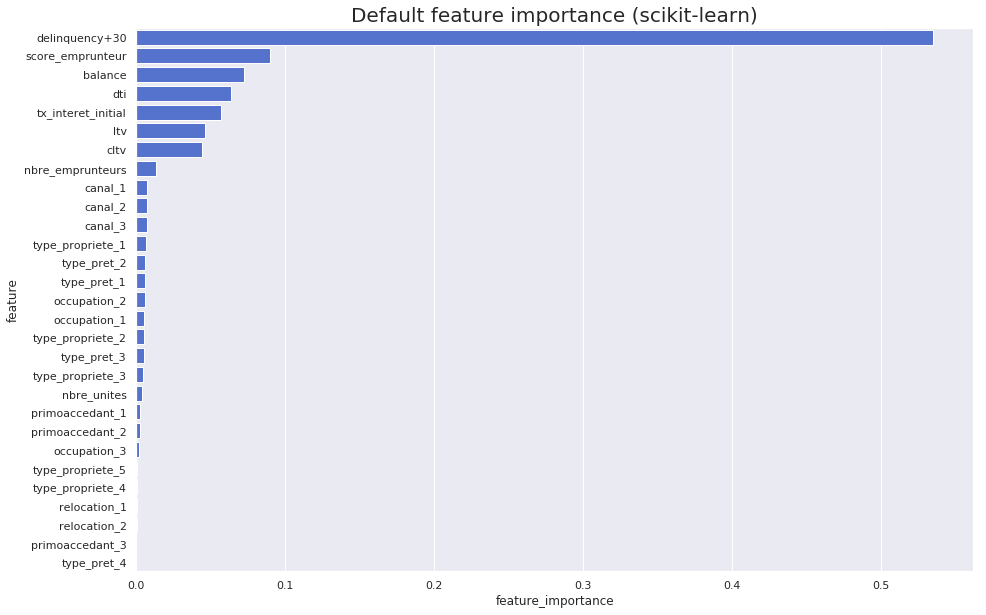

In [56]:
var_imp_plot(base_imp, 'Default feature importance (scikit-learn)')

We can see that the feature __on_default__ we have built is the most important one with a value of 0.53, the second most important feature is __score_emprunteur__ and it's a score developped by the fico company to measure the solvency of a client, it is logical that this feature is one of the most important although it got only a value of 0.09.

On the next part, we are going to see the impact of the features on the performance of a forecast model.